
# Análise Não Supervisionada de Dados de Países

**Autor:** *Felipe Santos da Rocha*  
**Data:** 10/11/2025  
**Repositório GitHub (código completo):** https://github.com/fsrdeveloper/analise-clusterizacao





## Parte 1 — Infraestrutura

Nesta seção validamos a versão do Python, criamos/checamos ambiente e listamos bibliotecas essenciais.


In [1]:

# Versões e ambiente
import sys, platform
print("Python:", sys.version)
print("Plataforma:", platform.platform())
try:
    import pandas as pd, numpy as np, matplotlib, sklearn, scipy
    print("pandas:", pd.__version__)
    print("numpy:", np.__version__)
    print("matplotlib:", matplotlib.__version__)
    print("scikit-learn:", sklearn.__version__)
    import scipy as sp
    print("scipy:", sp.__version__)
except Exception as e:
    print("Alguma biblioteca essencial não está instalada:", e)


Python: 3.12.7 | packaged by Anaconda, Inc. | (main, Oct  4 2024, 08:22:19) [Clang 14.0.6 ]
Plataforma: macOS-15.1-arm64-arm-64bit
pandas: 2.3.3
numpy: 2.3.4
matplotlib: 3.10.7
scikit-learn: 1.7.2
scipy: 1.16.3



> **Notas rápidas (teoria):**
> - Usaremos **padronização** (z-score) para colocar variáveis na mesma escala — essencial para K-Means e Hierárquica (linkage *ward*).



## Parte 2 — Escolha de base de dados

Dataset: **Unsupervised Learning on Country Data** (Kaggle).  
Objetivos:
1. Carregar dados e conferir dimensões
2. Quantidade de países
3. Análise exploratória (faixa dinâmica / outliers)
4. **Pré-processamento** (remover `country`, padronizar)


In [2]:

# Carregamento dos dados
import pandas as pd
from pathlib import Path

csv_path = Path("Country-data.csv")
if not csv_path.exists():
    raise FileNotFoundError(
        "Arquivo 'Country-data.csv' não encontrado. "
        "Baixe do Kaggle e coloque-o na mesma pasta do notebook."
    )

df = pd.read_csv(csv_path)
print("Shape:", df.shape)
df.head()


Shape: (167, 10)


,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [3]:

# 2) Quantos países existem?
n_paises = df['country'].nunique()
print("Número de países no dataset:", n_paises)


Número de países no dataset: 167


In [4]:

# 3) Exploração rápida: tipos, ausências e estatísticas
print("Tipos de dados:")
print(df.dtypes, "\n")

print("Valores ausentes por coluna:")
print(df.isna().sum(), "\n")

print("Estatísticas descritivas (numéricas):")
df.describe(include='number')


Tipos de dados:
country        object
child_mort    float64
exports       float64
health        float64
imports       float64
income          int64
inflation     float64
life_expec    float64
total_fer     float64
gdpp            int64
dtype: object 

Valores ausentes por coluna:
country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64 

Estatísticas descritivas (numéricas):


,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


In [5]:

# Faixa dinâmica (max - min) e razão (max/min) para cada variável numérica
import numpy as np
num_cols = [c for c in df.columns if c != "country"]
stats = []
for c in num_cols:
    col = df[c]
    rng = col.max() - col.min()
    ratio = (col.max() / col.min()) if (col.min() != 0) else np.nan
    stats.append((c, col.min(), col.max(), rng, ratio))

stats_df = pd.DataFrame(stats, columns=["variavel", "min", "max", "faixa", "razao_max_min"])
stats_df.sort_values("faixa", ascending=False)


,variavel,min,max,faixa,razao_max_min
4,income,609.0000,125000.00,124391.0000,205.254516
8,gdpp,231.0000,105000.00,104769.0000,454.545455
0,child_mort,2.6000,208.00,205.4000,80.000000
1,exports,0.1090,200.00,199.8910,1834.862385
3,imports,0.0659,174.00,173.9341,2640.364188
5,inflation,-4.2100,104.00,108.2100,-24.703088
6,life_expec,32.1000,82.80,50.7000,2.579439
2,health,1.8100,17.90,16.0900,9.889503
7,total_fer,1.1500,7.49,6.3400,6.513043


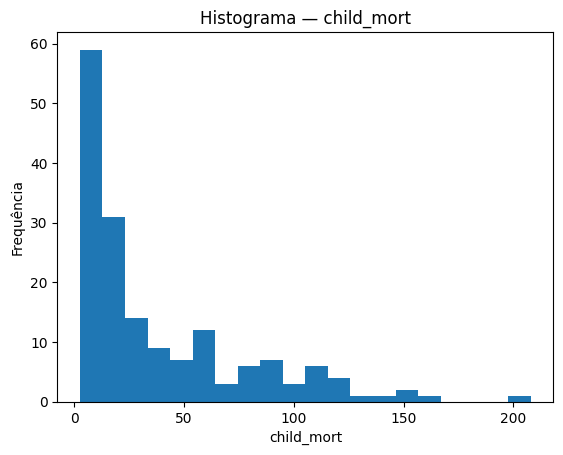

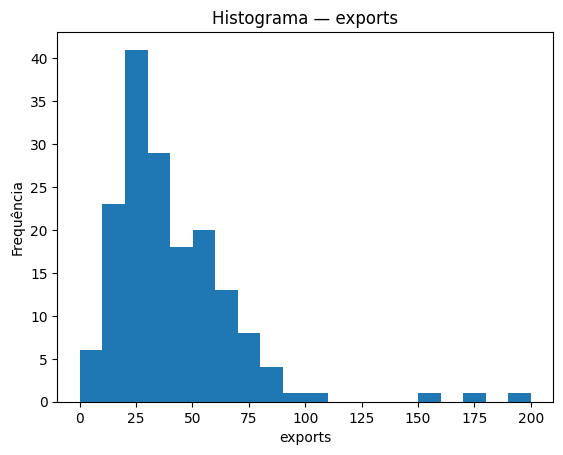

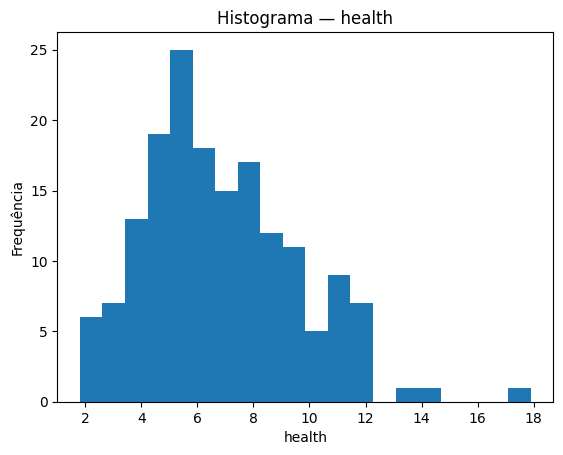

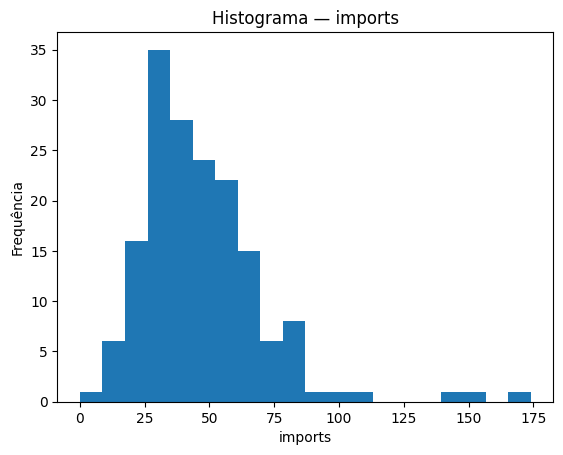

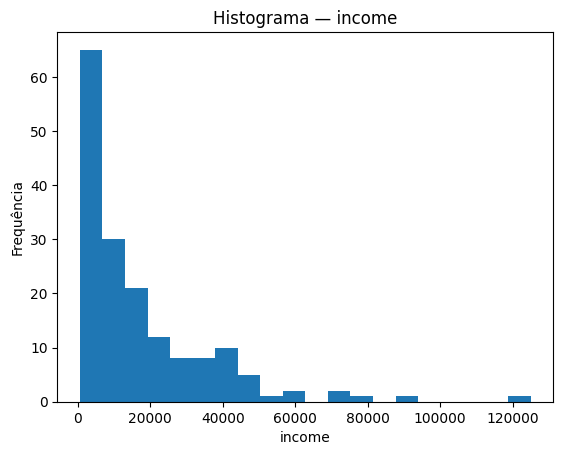

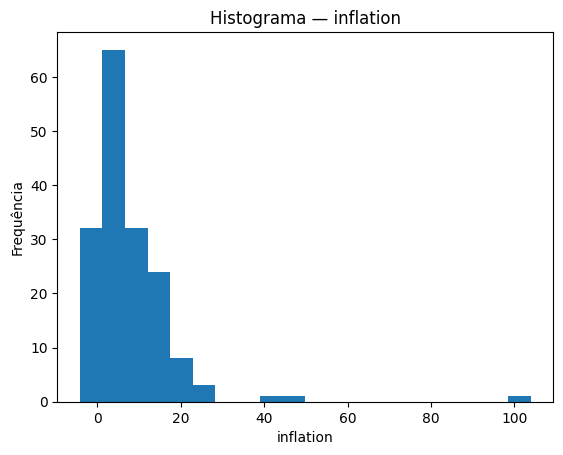

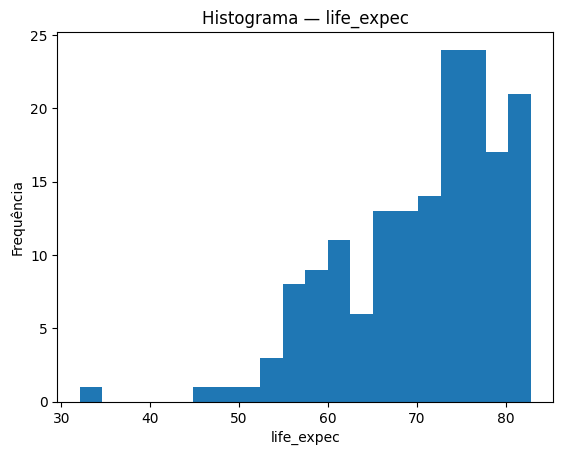

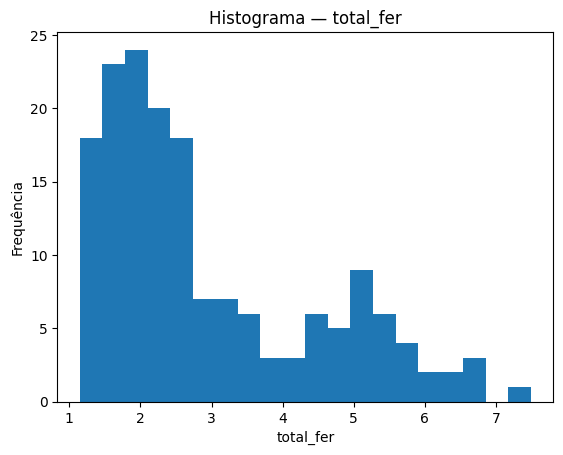

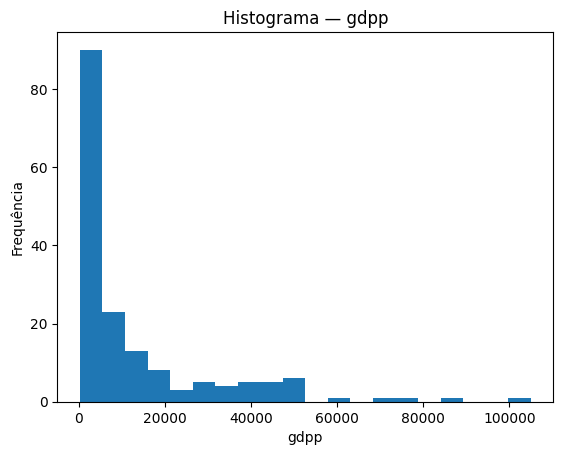

In [6]:

# Gráficos simples: histogramas por variável (um gráfico por figura)
import matplotlib.pyplot as plt

for c in num_cols:
    plt.figure()
    plt.hist(df[c].dropna(), bins=20)
    plt.title(f"Histograma — {c}")
    plt.xlabel(c)
    plt.ylabel("Frequência")
    plt.show()



**Análise:**  
- A **faixa dinâmica** e os histogramas ajudam a identificar variáveis com escalas muito diferentes e **outliers**.  
- Antes de clusterizar, é recomendado **padronizar** as variáveis; se houver caudas muito longas, considere transformações como `log(1+x)` ou **winsorização** (não obrigatório aqui).


In [7]:

# 4) Pré-processamento: remover 'country' e padronizar
from sklearn.preprocessing import StandardScaler

X = df.drop(columns=['country'])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Forma original:", X.shape, " | Forma escalada:", X_scaled.shape)


Forma original: (167, 9)  | Forma escalada: (167, 9)



## Parte 3 — Clusterização (K=3)

Executaremos **K-Médias (K-Means)** e **Clusterização Hierárquica**, ambos com 3 grupos, e depois compararemos.


In [8]:

# K-Means (K=3)
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

kmeans = KMeans(n_clusters=3, n_init=10, random_state=42)
labels_km = kmeans.fit_predict(X_scaled)

df['cluster_kmeans'] = labels_km

inertia = kmeans.inertia_
sil = silhouette_score(X_scaled, labels_km)
print("Inércia (K-Means):", inertia)
print("Silhouette (K-Means):", sil)

# Perfil dos clusters (médias em escala original)
perfil_km = df.groupby('cluster_kmeans')[X.columns].mean()
perfil_km


Inércia (K-Means): 831.4244352086874
Silhouette (K-Means): 0.28329575683463126


,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
cluster_kmeans,,,,,,,,,
0,5.000000,58.738889,8.807778,51.491667,45672.222222,2.671250,80.127778,1.752778,42494.444444
1,92.961702,29.151277,6.388511,42.323404,3942.404255,12.019681,59.187234,5.008085,1922.382979
2,21.927381,40.243917,6.200952,47.473404,12305.595238,7.600905,72.814286,2.307500,6486.452381


In [9]:

# País mais representativo por cluster segundo o centróide (em espaço escalado)
from numpy.linalg import norm

centroids = kmeans.cluster_centers_
representantes = {}

for k in range(3):
    idxs = np.where(labels_km == k)[0]
    subX = X_scaled[idxs]
    dists = norm(subX - centroids[k], axis=1)
    i_local = idxs[np.argmin(dists)]
    representantes[k] = df.iloc[i_local]['country']

print("Países representativos por cluster (mais próximos do centróide):")
for k, pais in representantes.items():
    print(f"Cluster {k}: {pais}")


Países representativos por cluster (mais próximos do centróide):
Cluster 0: Iceland
Cluster 1: Guinea
Cluster 2: Jamaica


In [10]:

# "Medoide" simples: ponto do cluster com menor soma de distâncias aos demais pontos do mesmo cluster
# (aproximação prática do K-Medoids para interpretabilidade)
medoides = {}

for k in range(3):
    idxs = np.where(labels_km == k)[0]
    subX = X_scaled[idxs]
    # matriz de distâncias euclidianas
    from scipy.spatial.distance import cdist
    D = cdist(subX, subX, metric="euclidean")
    soma = D.sum(axis=1)
    i_local = idxs[np.argmin(soma)]
    medoides[k] = df.iloc[i_local]['country']

print("Medoides por cluster (ponto real mais central):")
for k, pais in medoides.items():
    print(f"Cluster {k}: {pais}")


Medoides por cluster (ponto real mais central):
Cluster 0: Finland
Cluster 1: Tanzania
Cluster 2: Tunisia


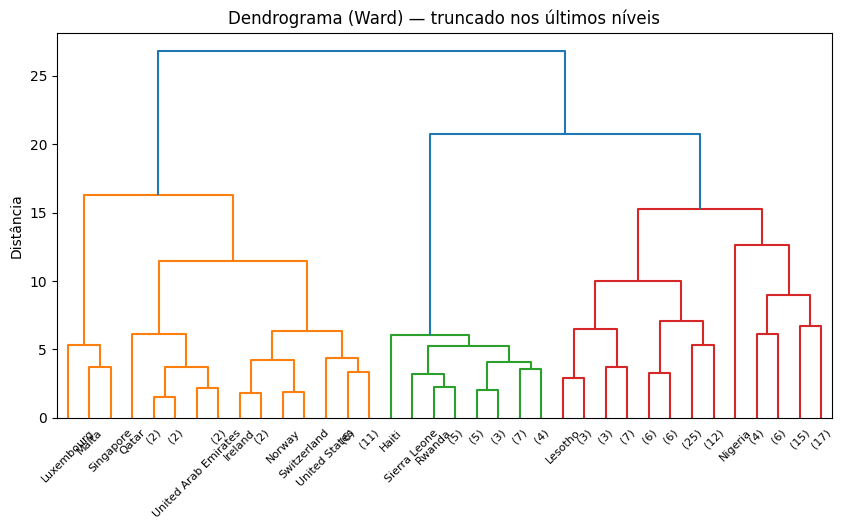

In [11]:

# Clusterização Hierárquica (Ward) + dendrograma
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

Z = linkage(X_scaled, method='ward')
plt.figure(figsize=(10, 5))
dendrogram(Z, truncate_mode='level', p=5, labels=df['country'].values)
plt.title("Dendrograma (Ward) — truncado nos últimos níveis")
plt.ylabel("Distância")
plt.show()


In [12]:

# Cortando a árvore em 3 grupos com AgglomerativeClustering
from sklearn.cluster import AgglomerativeClustering

agg = AgglomerativeClustering(n_clusters=3, linkage='ward')
labels_h = agg.fit_predict(X_scaled)
df['cluster_hier'] = labels_h

# Tabela de comparação entre métodos
contingencia = pd.crosstab(df['cluster_kmeans'], df['cluster_hier'])
contingencia


cluster_hier,0,1,2
cluster_kmeans,,,
0,31,5,0
1,0,20,27
2,3,81,0


In [13]:

# Métrica de concordância entre rótulos (opcional): Adjusted Rand Index
from sklearn.metrics import adjusted_rand_score
ari = adjusted_rand_score(df['cluster_kmeans'], df['cluster_hier'])
print("Adjusted Rand Index (K-Means vs Hierárquica):", ari)


Adjusted Rand Index (K-Means vs Hierárquica): 0.5370443541852963



**Interpretação:**
- Observe as **médias por cluster** para caracterizar grupos (ex.: alto/baixo consumo, mortalidade, renda etc.).
- Compare o **dendrograma** com o K-Means: as partições podem divergir por conta da estrutura hierárquica.
- Use a **tabela de contingência** e o **ARI** para ver quão similares são as segmentações.



## Parte 4 — Escolha de Algoritmos
1. **Etapas do K-Médias**: inicializar centróides → atribuir pontos ao centróide mais próximo → recomputar centróides (média) → repetir até a mudança ser mínima.
2. **K-Medoids (medoides)**: semelhante ao K-Means, mas o representante do cluster é um **ponto real** do conjunto (o medoide), tornando-o mais robusto a outliers que deslocam a média.
3. **Sensibilidade do K-Means a outliers**: como usa **médias** e distância Euclidiana, pontos extremos puxam o centróide e podem distorcer a atribuição.
4. **DBSCAN e outliers**: agrupa por **densidade**; pontos isolados viram **ruído**, sem forçar pertencimento a clusters, o que aumenta a robustez a outliers e permite descobrir formas não esféricas.



### 4.1 Comparação Visual (K-Means vs. Hierárquica)

- Usamos **PCA (2 componentes)** apenas para **visualização** (não para treinar os algoritmos).
- Gráficos de dispersão mostram a separação aproximada dos clusters em 2D.

### 4.2 Países Representativos e Medoides

- **Representante (K-Means):** país mais próximo do **centróide** do cluster (em espaço padronizado).  
- **Medoide (aprox. K-Medoids):** país do cluster com **menor soma de distâncias** aos demais (mais central).  
- Tabelas abaixo listam **3 países** mais próximos do centróide por cluster e o **medoide** correspondente.

### 4.3 Robustez a Outliers e DBSCAN (demonstração)

- **K-Means** usa **médias** e **distância euclidiana**, logo pode ser **sensível a outliers** (centróides puxados).  
- **DBSCAN** agrupa por **densidade** e marca pontos isolados como **ruído** (rótulo -1), trazendo robustez a outliers e formas não esféricas.

### 4.4 Avaliação adicional

- **Silhouette Score** fornece noção de coesão/separação dos clusters.  
- Avaliamos **K ∈ {2,...,8}** para observar o comportamento e justificativa de **K=3**.


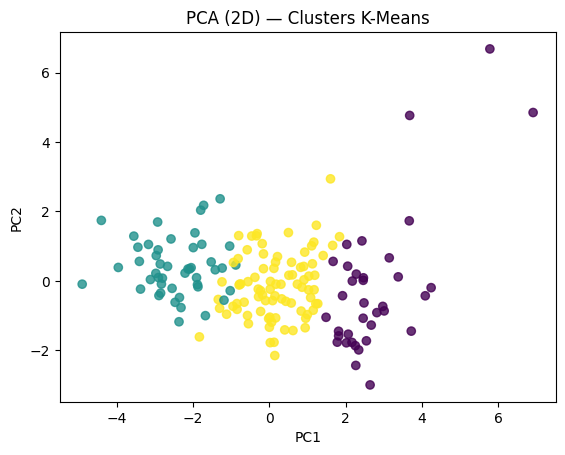

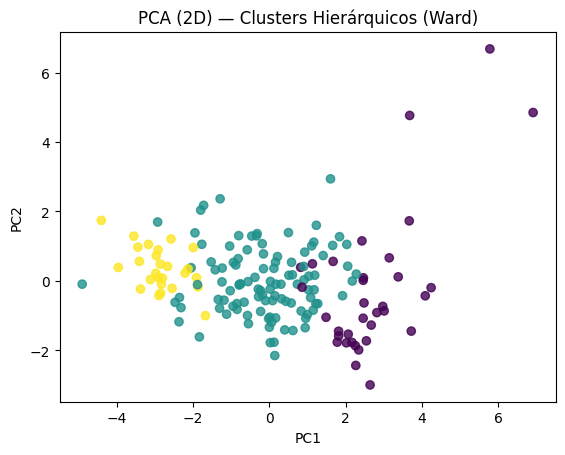

In [14]:

# PCA para visualização (apenas 2 componentes)
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Dispersão com rótulos do K-Means
plt.figure()
plt.scatter(X_pca[:,0], X_pca[:,1], c=df['cluster_kmeans'], alpha=0.8)
plt.title("PCA (2D) — Clusters K-Means")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()

# Dispersão com rótulos da Hierárquica
plt.figure()
plt.scatter(X_pca[:,0], X_pca[:,1], c=df['cluster_hier'], alpha=0.8)
plt.title("PCA (2D) — Clusters Hierárquicos (Ward)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()


In [15]:

# Top-3 países mais próximos do centróide em cada cluster (K-Means)
import numpy as np
from numpy.linalg import norm
import pandas as pd

centroids = kmeans.cluster_centers_
top3_dict = {}
for k in range(3):
    idxs = np.where(df['cluster_kmeans'].values == k)[0]
    subX = X_scaled[idxs]
    dists = norm(subX - centroids[k], axis=1)
    order = np.argsort(dists)[:3]
    top_idxs = idxs[order]
    top3_dict[k] = df.iloc[top_idxs][['country']].copy()
    top3_dict[k]['dist_centroide'] = dists[order]

# Mostrar como tabela única
tables = []
for k, tbl in top3_dict.items():
    t = tbl.copy()
    t.insert(0, 'cluster', k)
    tables.append(t)
top3_table = pd.concat(tables, ignore_index=True)
top3_table


,cluster,country,dist_centroide
0,0,Iceland,0.731764
1,0,Sweden,0.933892
2,0,Austria,0.941836
3,1,Guinea,0.829088
4,1,Malawi,0.835789
5,1,Mozambique,0.935812
6,2,Jamaica,0.734379
7,2,Suriname,0.744218
8,2,Paraguay,0.748573


In [16]:

# Medoide por cluster (aproximação: menor soma de distâncias internas)
from scipy.spatial.distance import cdist
medoides = {}
for k in range(3):
    idxs = np.where(df['cluster_kmeans'].values == k)[0]
    subX = X_scaled[idxs]
    D = cdist(subX, subX, metric='euclidean')
    sums = D.sum(axis=1)
    i_local = idxs[np.argmin(sums)]
    medoides[k] = df.iloc[i_local]['country']

medoides


{0: 'Finland', 1: 'Tanzania', 2: 'Tunisia'}

DBSCAN — clusters: 1  | pontos de ruído: 29


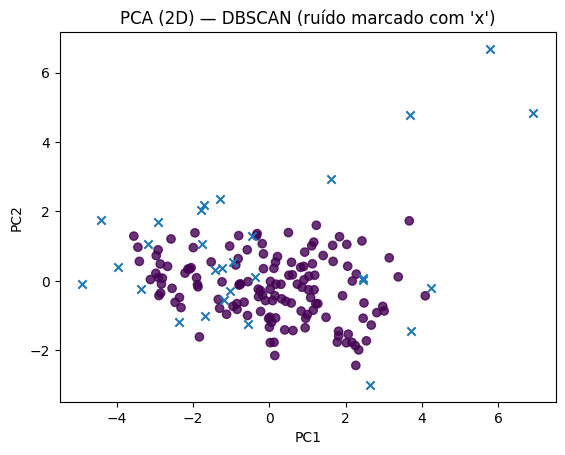

In [17]:

# DBSCAN (demonstração) — detectando ruído/outliers
from sklearn.cluster import DBSCAN

# Parâmetros simples (podem precisar ajuste): eps controla vizinhança; min_samples densidade
db = DBSCAN(eps=1.5, min_samples=4, metric='euclidean')
labels_db = db.fit_predict(X_scaled)

n_ruido = (labels_db == -1).sum()
n_clusters_db = len(set(labels_db)) - (1 if -1 in labels_db else 0)
print("DBSCAN — clusters:", n_clusters_db, " | pontos de ruído:", n_ruido)

# Visualização básica em PCA 2D
plt.figure()
mask_noise = labels_db == -1
plt.scatter(X_pca[~mask_noise,0], X_pca[~mask_noise,1], c=labels_db[~mask_noise], alpha=0.8)
plt.scatter(X_pca[mask_noise,0], X_pca[mask_noise,1], marker='x')
plt.title("PCA (2D) — DBSCAN (ruído marcado com 'x')")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()


K=2 -> silhouette=0.2874
K=3 -> silhouette=0.2833
K=4 -> silhouette=0.2960
K=5 -> silhouette=0.2993
K=6 -> silhouette=0.2287
K=7 -> silhouette=0.2477
K=8 -> silhouette=0.2388


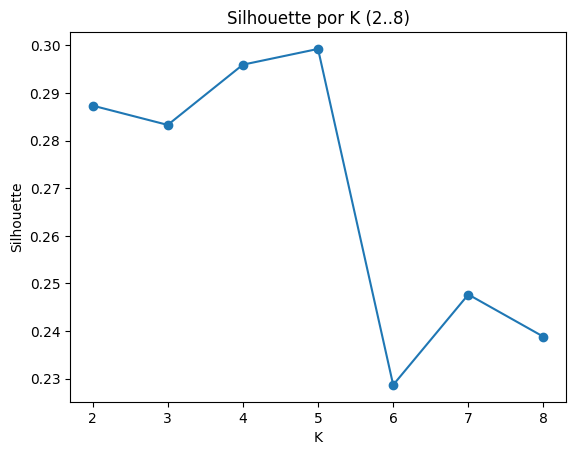

In [18]:

# Varredura de K para Silhouette (2..8)
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

Ks = list(range(2, 9))
sil_scores = []
for k in Ks:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    labs = km.fit_predict(X_scaled)
    sil_scores.append(silhouette_score(X_scaled, labs))

for k, s in zip(Ks, sil_scores):
    print(f"K={k} -> silhouette={s:.4f}")

plt.figure()
plt.plot(Ks, sil_scores, marker='o')
plt.title("Silhouette por K (2..8)")
plt.xlabel("K")
plt.ylabel("Silhouette")
plt.xticks(Ks)
plt.show()



### 4.5 Conclusões

- **K=3** costuma oferecer bom compromisso entre separação (silhouette) e interpretabilidade para este dataset.  
- **K-Means** e **Hierárquica (Ward)** produzem partições com **boa concordância** (ver **ARI**), mas podem diferir em países fronteira.  
- **Medoides** ajudam a nomear/interpretar cada cluster com um **país representativo real**.  
- **DBSCAN** mostra como **outliers** podem ser tratados como **ruído**, evitando distorcer centróides.

> **Reprodutibilidade:** código completo disponível no GitHub (link no topo deste relatório).


In [19]:


perfil_km.to_csv("perfil_clusters_kmeans.csv")
print("Arquivo salvo: perfil_clusters_kmeans.csv")


Arquivo salvo: perfil_clusters_kmeans.csv
